# 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

* 활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된  Naver sentiment movie corpus   

## <목차>
#### 1) 데이터 준비와 확인   

#### 2) 데이터로더 구성   

#### 3) 모델구성을 위한 데이터 분석 및 가공   

#### 4) 모델구성 및 validation set 구성   

#### 5) 모델 훈련 개시   

#### 6) Loss, Accuracy 그래프 시각화   

#### 7) 다른 모델들로 훈련, 그래프 그리기   

#### 8) 학습된 Embedding 레이어 분석      

#### 9) 한국어 Word2Vec 임베딩 활용하여 성능개선


## 1) 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from sklearn import model_selection

In [2]:
# 데이터를 읽어보기
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
print(len(train_data.document), len(train_data.label))
print(len(test_data.document), len(test_data.label))

150000 150000
50000 50000


## 2) 데이터로더 구성   
* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴

In [4]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    # pad, bos, unk, unused 를 제외하고 가장 자주나오는 만개의 단어를 가져오기
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [5]:
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

146182 49157
146182 49157


In [6]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델구성을 위한 데이터 분석 및 가공   
* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [8]:
print("X_train's length :", len(X_train))
print("X_test's length :", len(X_test))

X_train's length : 146182
X_test's length : 49157


In [9]:
#전체 데이터 셋 통합
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [10]:
# padding방식을 문장 뒤쪽(post), 앞쪽(pre)중 어느쪽으로 하느냐에 따라서 성능차이 발생
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 4) 모델구성 및 validation set 구성

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                          y_train,
                                                          test_size=0.2,
                                                          shuffle=True, 
                                                          random_state=20)

In [12]:
#Conv1D
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 32  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(32, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          3600      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          3616      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

## 5) 모델 훈련 개시

In [13]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
batch_size=512

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    verbose=2)

Epoch 1/20
229/229 - 9s - loss: 0.4537 - accuracy: 0.7838 - val_loss: 0.3560 - val_accuracy: 0.8434
Epoch 2/20
229/229 - 2s - loss: 0.3096 - accuracy: 0.8691 - val_loss: 0.3437 - val_accuracy: 0.8518
Epoch 3/20
229/229 - 2s - loss: 0.2592 - accuracy: 0.8947 - val_loss: 0.3474 - val_accuracy: 0.8502
Epoch 4/20
229/229 - 2s - loss: 0.2030 - accuracy: 0.9237 - val_loss: 0.3869 - val_accuracy: 0.8469
Epoch 5/20
229/229 - 2s - loss: 0.1475 - accuracy: 0.9484 - val_loss: 0.4365 - val_accuracy: 0.8417
Epoch 6/20
229/229 - 2s - loss: 0.1031 - accuracy: 0.9664 - val_loss: 0.5089 - val_accuracy: 0.8345
Epoch 7/20
229/229 - 2s - loss: 0.0758 - accuracy: 0.9764 - val_loss: 0.5802 - val_accuracy: 0.8321
Epoch 8/20
229/229 - 2s - loss: 0.0567 - accuracy: 0.9830 - val_loss: 0.6551 - val_accuracy: 0.8300
Epoch 9/20
229/229 - 2s - loss: 0.0450 - accuracy: 0.9870 - val_loss: 0.7237 - val_accuracy: 0.8270
Epoch 10/20
229/229 - 2s - loss: 0.0373 - accuracy: 0.9889 - val_loss: 0.7940 - val_accuracy: 0.8248

In [14]:
#학습이 끝난 모델을 테스트 셋으로 평가해보기
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 1.2298 - accuracy: 0.8194
[1.2298457622528076, 0.8193542957305908]


## 6) Loss, Accuracy 그래프 시각화

In [15]:
# 모델의 fitting 과정 중의 정보들이 history 변수에 저장
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


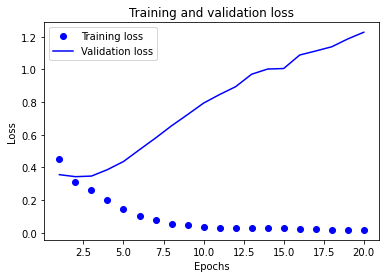

In [16]:
# 도식화 Training and Validation loss
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

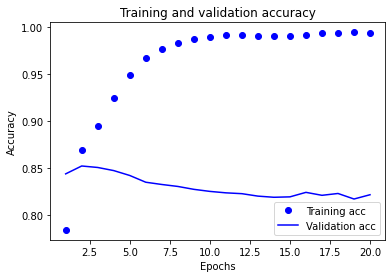

In [17]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7) 다른 모델들로 훈련, 그래프 그리기

In [18]:
# 2) CNN 계열의 GlobalMaxPooling1D() 활용하기 (정해진 필터 크기에서 최댓값 추출) 
model = keras.Sequential(name='GlobalMaxPooling1D') 
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) 
model.add(keras.layers.GlobalMaxPooling1D()) 
model.add(keras.layers.Dense(8, activation='relu')) 
model.add(keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim 입니다. 
model.summary()

Model: "GlobalMaxPooling1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 320,273
Trainable params: 320,273
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
batch_size=512

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    verbose=2)

Epoch 1/20
229/229 - 2s - loss: 0.5466 - accuracy: 0.7718 - val_loss: 0.3978 - val_accuracy: 0.8285
Epoch 2/20
229/229 - 1s - loss: 0.3506 - accuracy: 0.8510 - val_loss: 0.3556 - val_accuracy: 0.8443
Epoch 3/20
229/229 - 1s - loss: 0.3029 - accuracy: 0.8736 - val_loss: 0.3518 - val_accuracy: 0.8479
Epoch 4/20
229/229 - 1s - loss: 0.2724 - accuracy: 0.8887 - val_loss: 0.3573 - val_accuracy: 0.8470
Epoch 5/20
229/229 - 1s - loss: 0.2480 - accuracy: 0.9010 - val_loss: 0.3674 - val_accuracy: 0.8470
Epoch 6/20
229/229 - 1s - loss: 0.2265 - accuracy: 0.9110 - val_loss: 0.3817 - val_accuracy: 0.8457
Epoch 7/20
229/229 - 1s - loss: 0.2072 - accuracy: 0.9200 - val_loss: 0.3974 - val_accuracy: 0.8433
Epoch 8/20
229/229 - 1s - loss: 0.1891 - accuracy: 0.9287 - val_loss: 0.4160 - val_accuracy: 0.8409
Epoch 9/20
229/229 - 1s - loss: 0.1725 - accuracy: 0.9368 - val_loss: 0.4355 - val_accuracy: 0.8380
Epoch 10/20
229/229 - 1s - loss: 0.1568 - accuracy: 0.9434 - val_loss: 0.4612 - val_accuracy: 0.8367

In [20]:
#학습이 끝난 모델을 테스트 셋으로 평가해보기
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.7111 - accuracy: 0.8218
[0.7111096978187561, 0.8218157887458801]


In [21]:
# 모델의 fitting 과정 중의 정보들이 history 변수에 저장
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


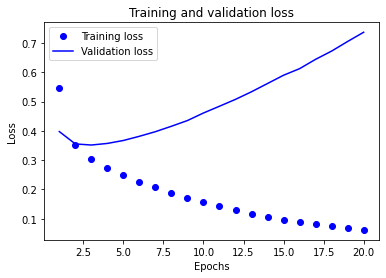

In [22]:
# 도식화 Training and Validation loss
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

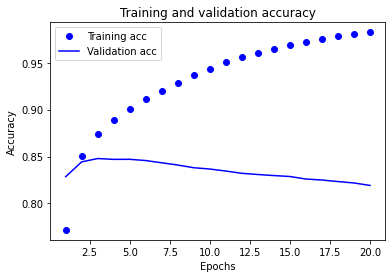

In [23]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [24]:
# 1) LSTM 모델 
model = keras.Sequential(name='LSTM') 
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) 
model.add(keras.layers.LSTM(8)) # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능) 
model.add(keras.layers.Dense(8, activation='relu')) 
model.add(keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim 입니다. 
model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1312      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 321,393
Trainable params: 321,393
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
batch_size=512

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    verbose=2)

Epoch 1/20
229/229 - 5s - loss: 0.5056 - accuracy: 0.7659 - val_loss: 0.3770 - val_accuracy: 0.8404
Epoch 2/20
229/229 - 3s - loss: 0.3416 - accuracy: 0.8562 - val_loss: 0.3573 - val_accuracy: 0.8476
Epoch 3/20
229/229 - 3s - loss: 0.3164 - accuracy: 0.8691 - val_loss: 0.3562 - val_accuracy: 0.8450
Epoch 4/20
229/229 - 3s - loss: 0.3037 - accuracy: 0.8749 - val_loss: 0.3548 - val_accuracy: 0.8469
Epoch 5/20
229/229 - 3s - loss: 0.2934 - accuracy: 0.8785 - val_loss: 0.3571 - val_accuracy: 0.8457
Epoch 6/20
229/229 - 3s - loss: 0.2829 - accuracy: 0.8839 - val_loss: 0.3581 - val_accuracy: 0.8449
Epoch 7/20
229/229 - 2s - loss: 0.2719 - accuracy: 0.8888 - val_loss: 0.3576 - val_accuracy: 0.8480
Epoch 8/20
229/229 - 3s - loss: 0.2596 - accuracy: 0.8941 - val_loss: 0.3611 - val_accuracy: 0.8483
Epoch 9/20
229/229 - 3s - loss: 0.2469 - accuracy: 0.8993 - val_loss: 0.3621 - val_accuracy: 0.8500
Epoch 10/20
229/229 - 3s - loss: 0.2344 - accuracy: 0.9042 - val_loss: 0.3782 - val_accuracy: 0.8506

In [26]:
#학습이 끝난 모델을 테스트 셋으로 평가해보기
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.5446 - accuracy: 0.8389
[0.5446363687515259, 0.8388835787773132]


In [27]:
# 모델의 fitting 과정 중의 정보들이 history 변수에 저장
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


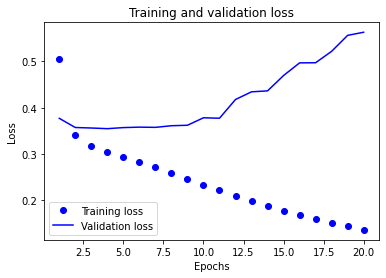

In [28]:
# 도식화 Training and Validation loss
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

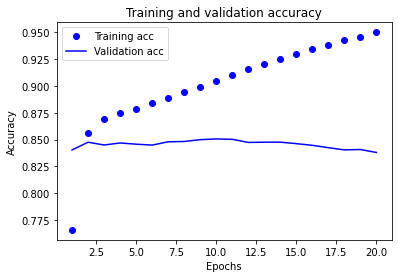

In [29]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 8) 학습된 Embedding 레이어 분석

In [30]:
#이 layer를 통해서 학습이 잘 이루어졌는지 분석할 수 있음
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 32)


In [31]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀쓰기

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [32]:
#gensim에서 제공하는 패키지를 이용해서 위에 남긴 임베딩 파라미터를 읽어서 
#word vector로 활용할 수 있음
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([ 0.09604965, -0.03910665, -0.01692378,  0.20616168,  0.00427277,
        0.02639204,  0.06124254,  0.04539061,  0.00552979,  0.12049825,
        0.058594  ,  0.0531842 , -0.00919174, -0.12583639, -0.2122458 ,
        0.01108995,  0.00707466,  0.12859096, -0.06481827, -0.01561789,
        0.14029601,  0.05127233,  0.07202888,  0.08868421,  0.04882639,
        0.04973252, -0.04555891, -0.03848054,  0.19267875, -0.04833218,
        0.09847047,  0.05901657], dtype=float32)

In [33]:
word_vectors.similar_by_word("주인공")

[('을지', 0.5937991142272949),
 ('3', 0.58426833152771),
 ('첨', 0.559149980545044),
 ('주온', 0.5589323043823242),
 ('을', 0.5584535002708435),
 ('1', 0.5569790601730347),
 ('초반', 0.555072009563446),
 ('오글거리', 0.5548245906829834),
 ('인디', 0.5546802282333374),
 ('바른', 0.5465383529663086)]

In [34]:
word_vectors.similar_by_word("감동")

[('최소', 0.8940329551696777),
 ('불러일으키', 0.8877789974212646),
 ('줬었', 0.8815678358078003),
 ('먹먹', 0.8813018798828125),
 ('당연히', 0.8790113925933838),
 ('전율', 0.8750501871109009),
 ('best', 0.8668700456619263),
 ('어울려요', 0.8661370873451233),
 ('깨달음', 0.8647298812866211),
 ('손색없', 0.8639535903930664)]

연관된 단어를 word2vec를 이용해서 뽑아낼 수 있는데
보이는 것과 같이 그렇게 성능이 좋지는 않음

## 9) 한국어 Word2Vec 임베딩 활용하여 성능개선

In [35]:
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec 

  

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
ko_model = Word2Vec.load(word2vec_path)
ko_model.wv.most_similar("주인공")

[('여주인공', 0.7362918853759766),
 ('히로인', 0.7030971646308899),
 ('원작', 0.6740964651107788),
 ('악당', 0.6630157232284546),
 ('등장인물', 0.6590856909751892),
 ('악역', 0.6446496248245239),
 ('작중', 0.627465546131134),
 ('극중', 0.6266964077949524),
 ('유령', 0.609932541847229),
 ('모험', 0.5971505641937256)]

In [36]:
ko_model.similar_by_word("감동")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('감명', 0.7177015542984009),
 ('감격', 0.6908231973648071),
 ('실망', 0.6267645359039307),
 ('감화', 0.6191877126693726),
 ('감탄', 0.6140128374099731),
 ('칭찬', 0.6059398055076599),
 ('존경', 0.6032299995422363),
 ('자극', 0.594598650932312),
 ('감복', 0.5902734994888306),
 ('호응', 0.5850393772125244)]

In [37]:
vector = ko_model['주인공']
vector

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-1.5204564e+00, -2.8309917e+00,  4.8951966e-01,  2.8373489e-01,
       -1.5701252e+00, -6.1594337e-01, -7.0439458e-02,  1.7730820e+00,
        7.4497163e-01,  2.9538804e-01,  1.3747534e+00,  1.4218109e+00,
        6.4636153e-01,  2.9953018e-01,  1.6863719e-01,  7.3786944e-01,
        9.0953058e-01,  1.3055873e+00,  1.3363632e+00, -5.6929622e-02,
       -4.6752492e-01, -4.4766888e-01, -2.4217651e-03,  5.7588112e-01,
       -5.5181080e-01, -1.3734692e+00,  1.4425172e+00,  1.8638158e+00,
       -7.4512875e-01,  8.9056063e-01,  7.9167700e-01, -5.9433389e-03,
        5.5219036e-01, -1.3048128e+00, -4.1383523e-02, -3.7023616e-01,
        7.2620936e-02,  4.1201523e-01, -2.8611928e-01,  3.3965874e-01,
        7.3672801e-02,  3.9606860e-01, -6.5436530e-01, -2.0602055e+00,
        1.6352504e-01, -5.9697056e-01,  1.0825907e-01, -3.7962955e-01,
       -1.0607311e+00,  3.0427629e-01,  7.8090608e-02, -9.6169323e-01,
        7.9417849e-01, -1.0393640e+00, -1.9971159e+00, -1.2392480e+00,
      

In [38]:
vector = ko_model['감동']
vector

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-1.4411083 , -0.78142536,  2.453768  , -0.86445606,  0.24195324,
        0.36006922, -1.0639709 ,  0.85037315, -1.0184479 ,  0.21196692,
       -0.6679936 ,  0.6389819 , -0.26964295,  0.66028535,  0.39613017,
        0.6428288 ,  0.6648245 ,  0.08363932, -0.2540794 ,  0.55310047,
        0.63392764,  0.19311981, -0.4648248 ,  0.1490374 ,  2.0762694 ,
        0.7872764 , -0.21711552, -0.59049505, -1.3264338 , -0.06233318,
        1.2550159 , -0.05334642, -0.5453753 , -0.8736315 ,  0.5253877 ,
        0.03122815,  0.8280226 ,  0.23597455,  0.06136359,  1.5114233 ,
       -0.340495  ,  0.912277  ,  0.5899006 , -1.3025732 , -0.87596595,
        0.21738248,  1.0366931 , -0.55709684, -0.9039502 ,  0.28133616,
       -1.7572548 , -0.29769212, -0.14536098,  0.5850025 , -0.6111547 ,
       -0.29829553,  1.4106004 , -0.38685524,  0.4801454 ,  0.40166005,
        0.28174093,  1.6133646 , -0.8590998 ,  0.49886975,  0.38605362,
       -0.1607663 , -0.87983316,  0.21996935,  0.68561727, -0.84

In [39]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_model:
        embedding_matrix[i] = ko_model[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [40]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000   # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(512))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               1460224   
_________________________________________________________________
dense_6 (Dense)              (None, 16)                8208      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 3,468,449
Trainable params: 3,468,449
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
batch_size=512

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    verbose=2)

Epoch 1/20
229/229 - 37s - loss: 0.4477 - accuracy: 0.7850 - val_loss: 0.3662 - val_accuracy: 0.8373
Epoch 2/20
229/229 - 35s - loss: 0.3180 - accuracy: 0.8627 - val_loss: 0.3168 - val_accuracy: 0.8641
Epoch 3/20
229/229 - 35s - loss: 0.2701 - accuracy: 0.8863 - val_loss: 0.3111 - val_accuracy: 0.8657
Epoch 4/20
229/229 - 35s - loss: 0.2309 - accuracy: 0.9059 - val_loss: 0.3144 - val_accuracy: 0.8674
Epoch 5/20
229/229 - 35s - loss: 0.1893 - accuracy: 0.9244 - val_loss: 0.3441 - val_accuracy: 0.8672
Epoch 6/20
229/229 - 35s - loss: 0.1461 - accuracy: 0.9431 - val_loss: 0.3849 - val_accuracy: 0.8663
Epoch 7/20
229/229 - 35s - loss: 0.1059 - accuracy: 0.9595 - val_loss: 0.4445 - val_accuracy: 0.8630
Epoch 8/20
229/229 - 35s - loss: 0.0734 - accuracy: 0.9725 - val_loss: 0.4994 - val_accuracy: 0.8607
Epoch 9/20
229/229 - 36s - loss: 0.0556 - accuracy: 0.9788 - val_loss: 0.6025 - val_accuracy: 0.8596
Epoch 10/20
229/229 - 35s - loss: 0.0418 - accuracy: 0.9839 - val_loss: 0.6736 - val_accura

#### 정확도가 0.8573으로 위에보다는 조금 올라간 것을 알 수 있음

In [43]:
# 모델의 fitting 과정 중의 정보들이 history 변수에 저장
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


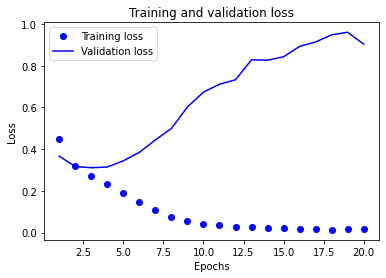

In [44]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

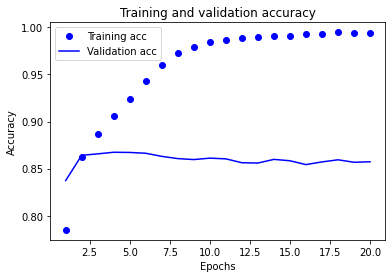

In [45]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 🤔회고

### 잘 안된부분😢 :     

9)한국어 Word2Vec 임베딩 활용하여 성능개선할때 
> Can't get attribute 'Vocab' on <module 'gensim.models.word2vec' from '/opt/conda/lib/python3.7/site-packages/gensim/models/word2vec.py'>

이라는 에러가 떴었는데 진영님👍께서 젠심 버전이 4가 넘어가서 나는 에러라고 알려주시면서 pip install -U gensim==3.8.3을 클라우드 쉘에 다운하라고 알려주셔서 다운받고 다시 실행하니까 제대로 실행이 되었다.     


### 느낀점🤔 :     
아직 모델설계부분은 많이 부족한 것 같다. 사실 전체적으로 구현하기에도 부족하지만 한국어 Word2Vec 임베딩활용해서 성능 개선 하는 부분 처럼 비슷하게 연관된 단어들을 보여주는 걸 보면 또 신기해서 흥미가 좀 생기기도 했다.      

시각화 부분도 다르게 해볼 껄 하는 아쉬움도 남는다. 시간 분배를 좀 잘해서 시간을 두고 완성도 높은 결과물을 낼 수 있도록 노력해야겠다.     



